In [1]:
from IPython.display import Image

- batch
- streaming 
    - micro batch style : 적당량의 데이터를 쌓아두고 처리 
        - size : 시간단위 ( spark engine )
    - one by one style : 1건씩 처리
    
    - RDD Series : 시간의 흐름에 따라 RDD 처리 
    - DataFrame : append , unbounded 
        - 시간이 흐름에 따라 데이터가 쌓임 (집계된 결과를 가지고 있음) 
        - 제약이 많음

-----
#### hadoop-worker-03 jar file upload

 - google Drive 강의자료 0421에 올라온 jar파일 다운로드

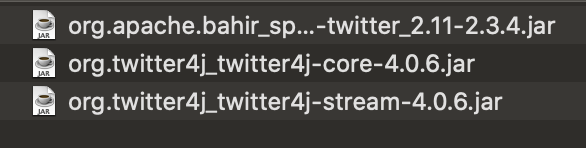

In [2]:
Image('./capture/upload.png')

$ sudo cp /home/dalgona91/org.apache.bahir_spark-streaming-twitter_2.11-2.3.4.jar /kikang/spark2
/

$ sudo cp /home/dalgona91/org.twitter4j_twitter4j-core-4.0.6.jar /kikang/spark2/

$ sudo cp /home/dalgona91/org.twitter4j_twitter4j-stream-4.0.6.jar /kikang/spark2/

$ sudo chown hadoop:hadoop ./org.*

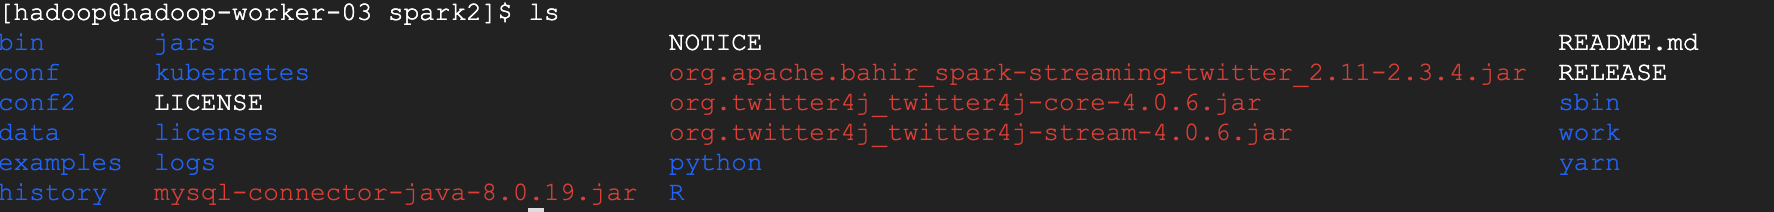

In [3]:
Image('./capture/upload_02.png')

spark3 interpreter

 - spark.jars.packages // org.apache.bahir:spark-streaming-twitter_2.11:2.3.4

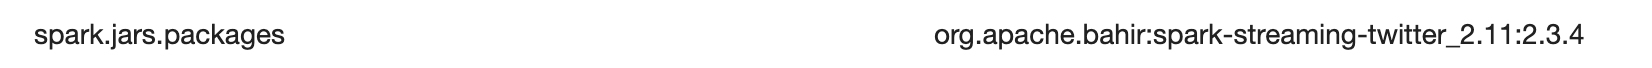

In [4]:
Image('./capture/01_twitter.png')

* 지난주 데이터 쭉 다시 실행 

----
    %sql
    select * 
    from topCounts60
    where count > 3
    order by count desc

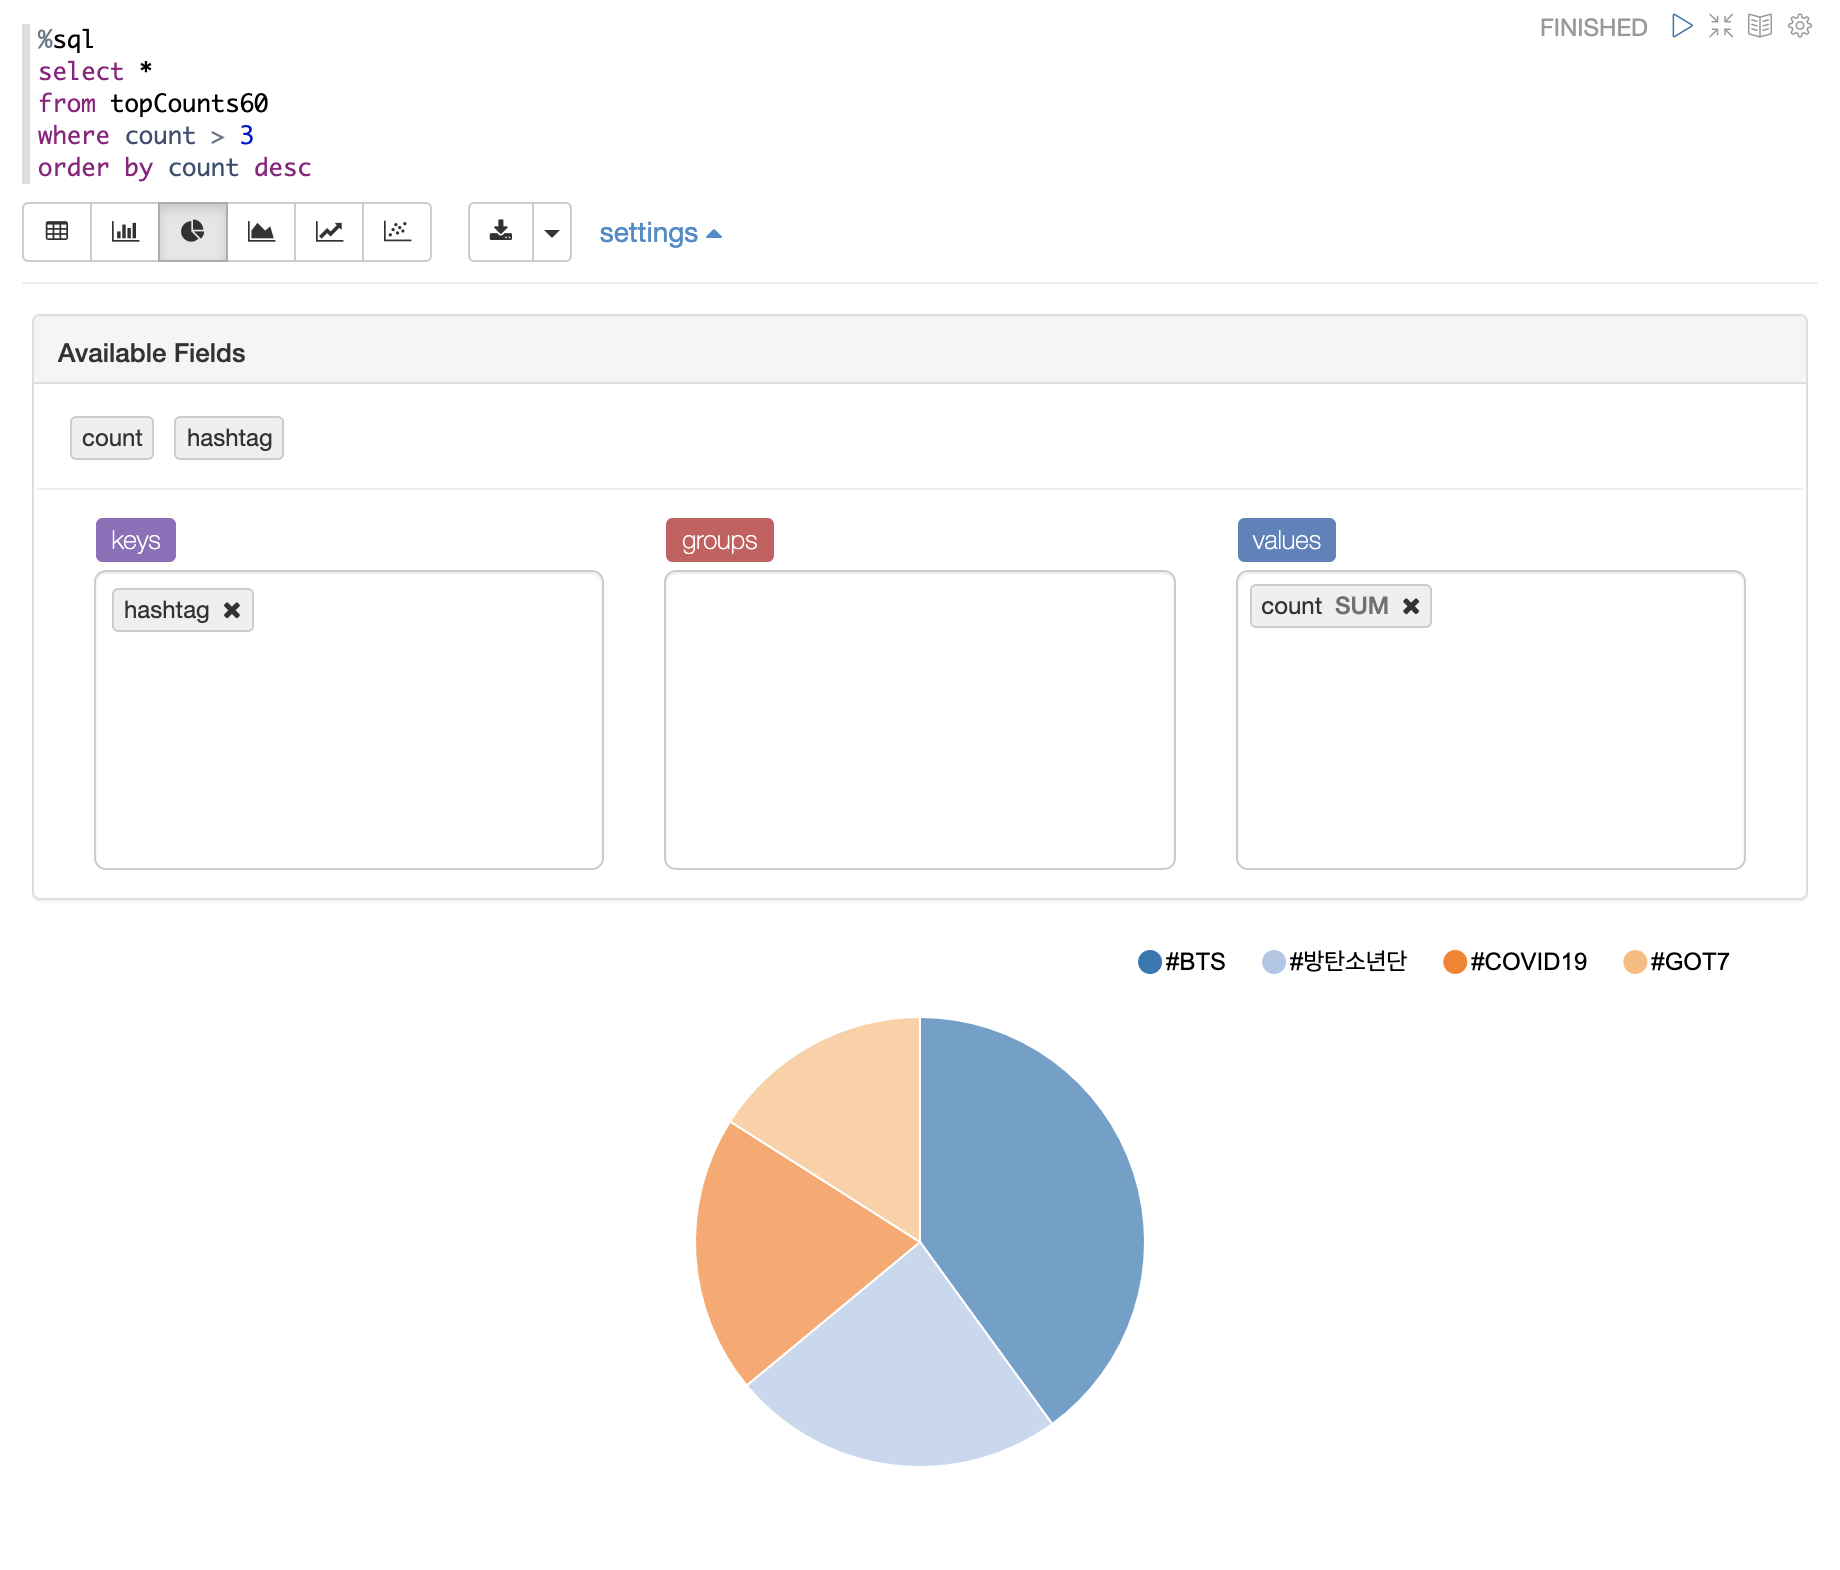

In [6]:
Image('./capture/02_twitter.png')

-----
    %sql
    show tables
    

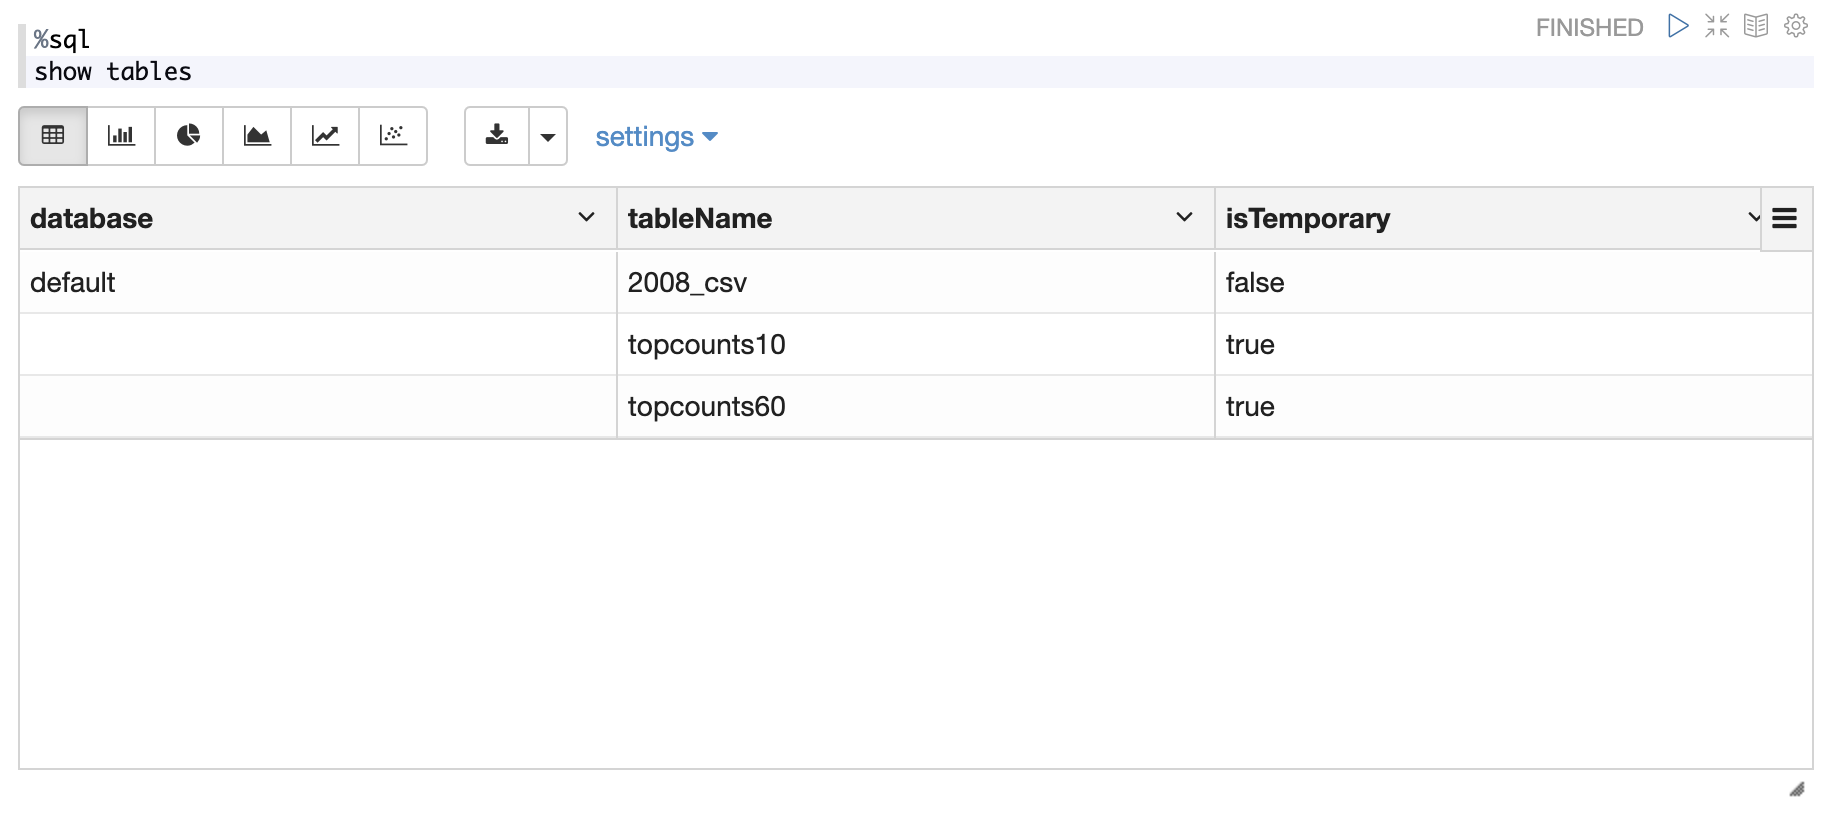

In [7]:
Image('./capture/03_twitter.png')

-----
#### 60초 DF를 DW에 Table로 영구 저장 (append mode)

    topCounts60.foreachRDD(rdd => {
        rdd.toDF("count", "hashtag").write.mode("append").saveAsTable("topCounts60DF")
        })
        
#### 10초 DF를 DW에 Table로 영구 저장 (overwrite mode)

    topCounts10.foreachRDD(rdd => {
        rdd.toDF("count", "hashtag").write.mode("overwrite").saveAsTable("topCounts10DF")
        })


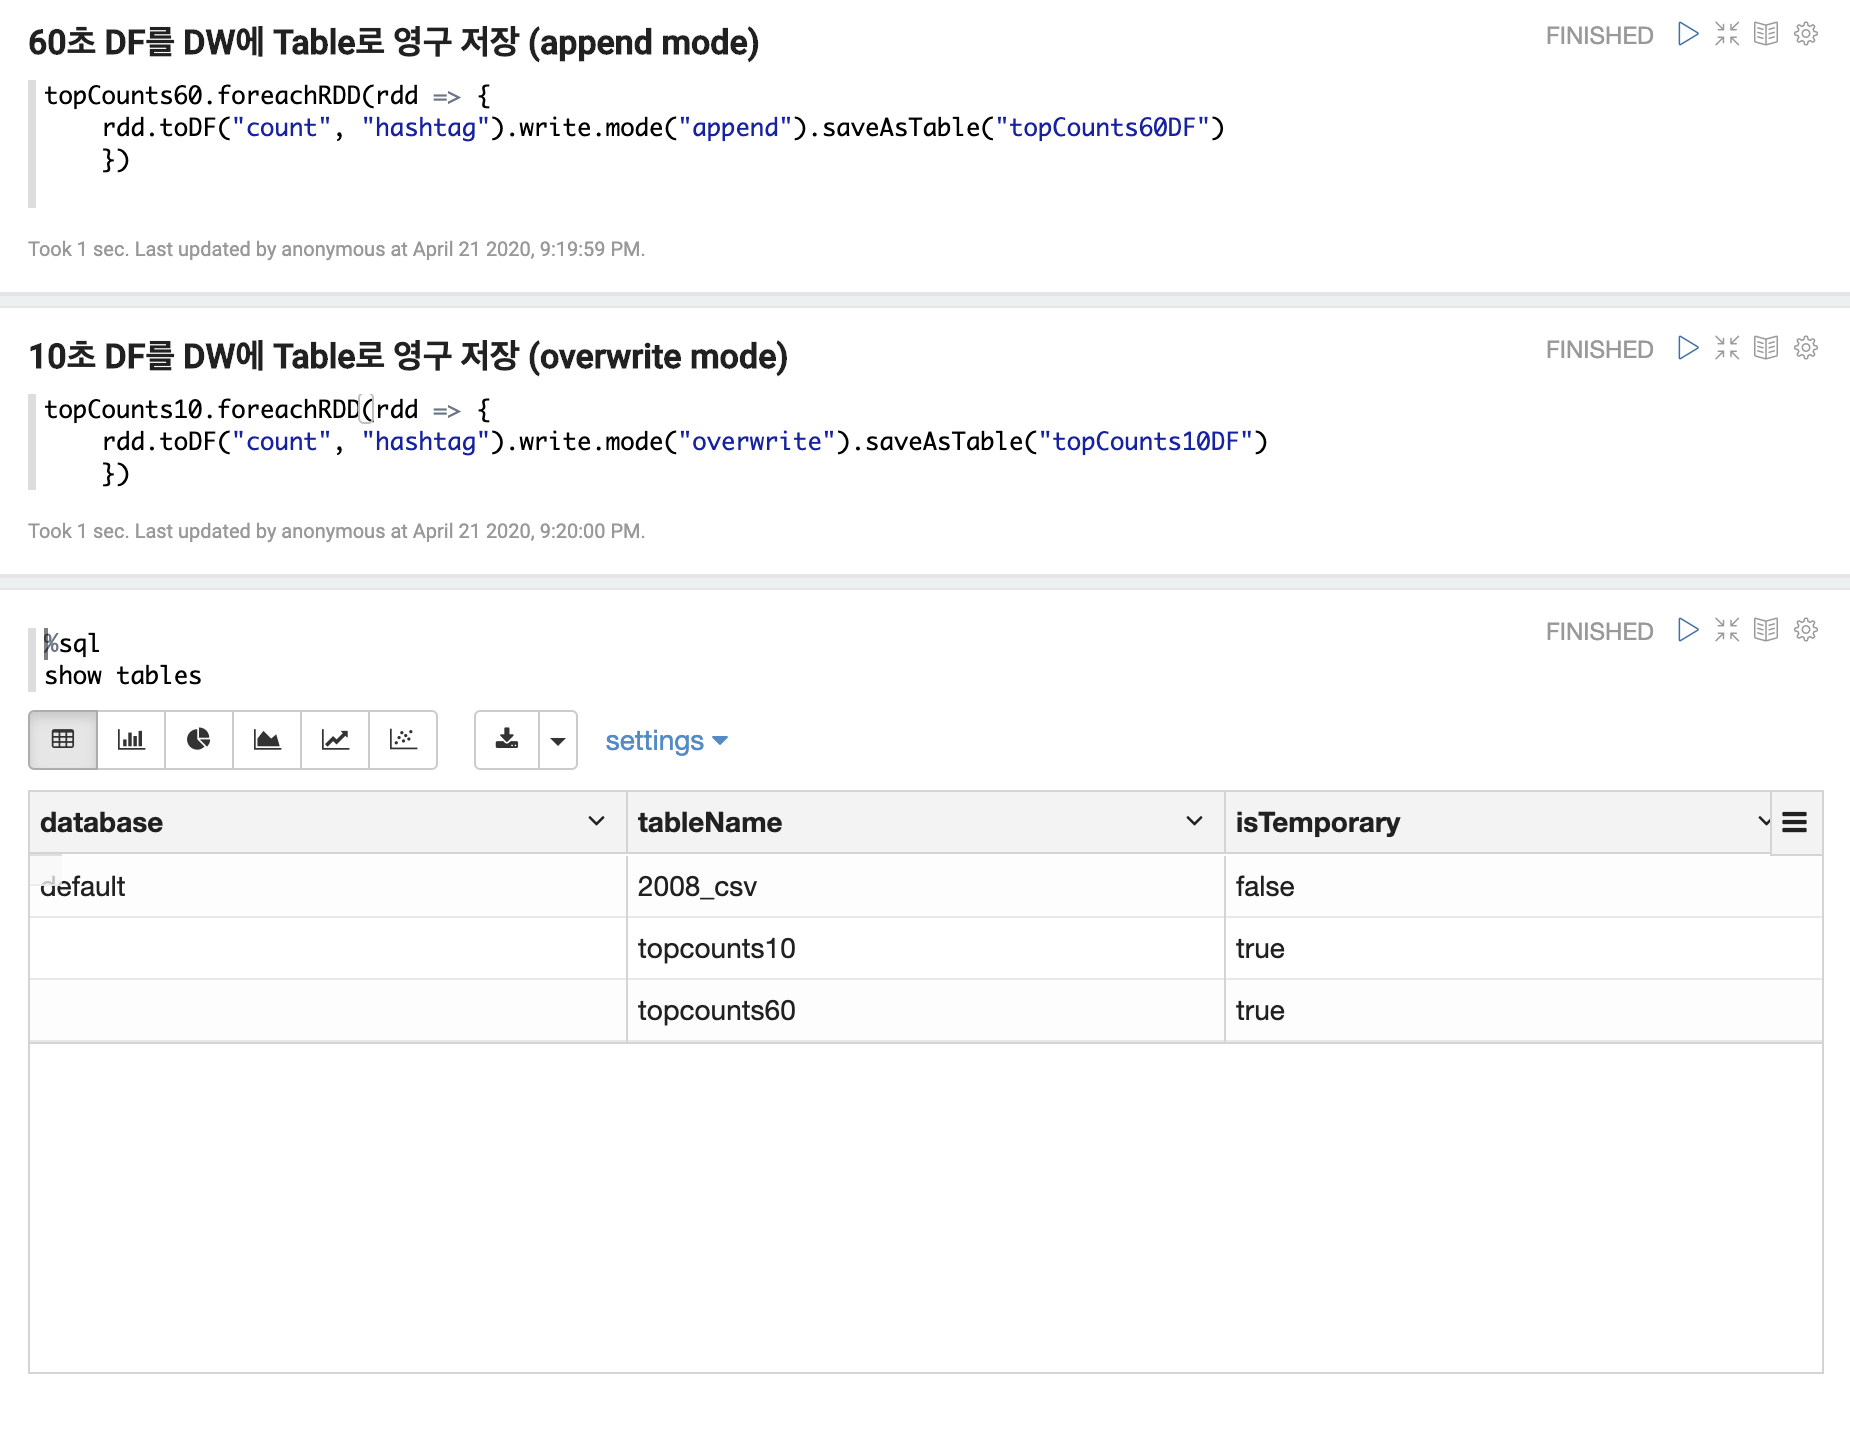

In [8]:
Image('./capture/04_twitter.png')

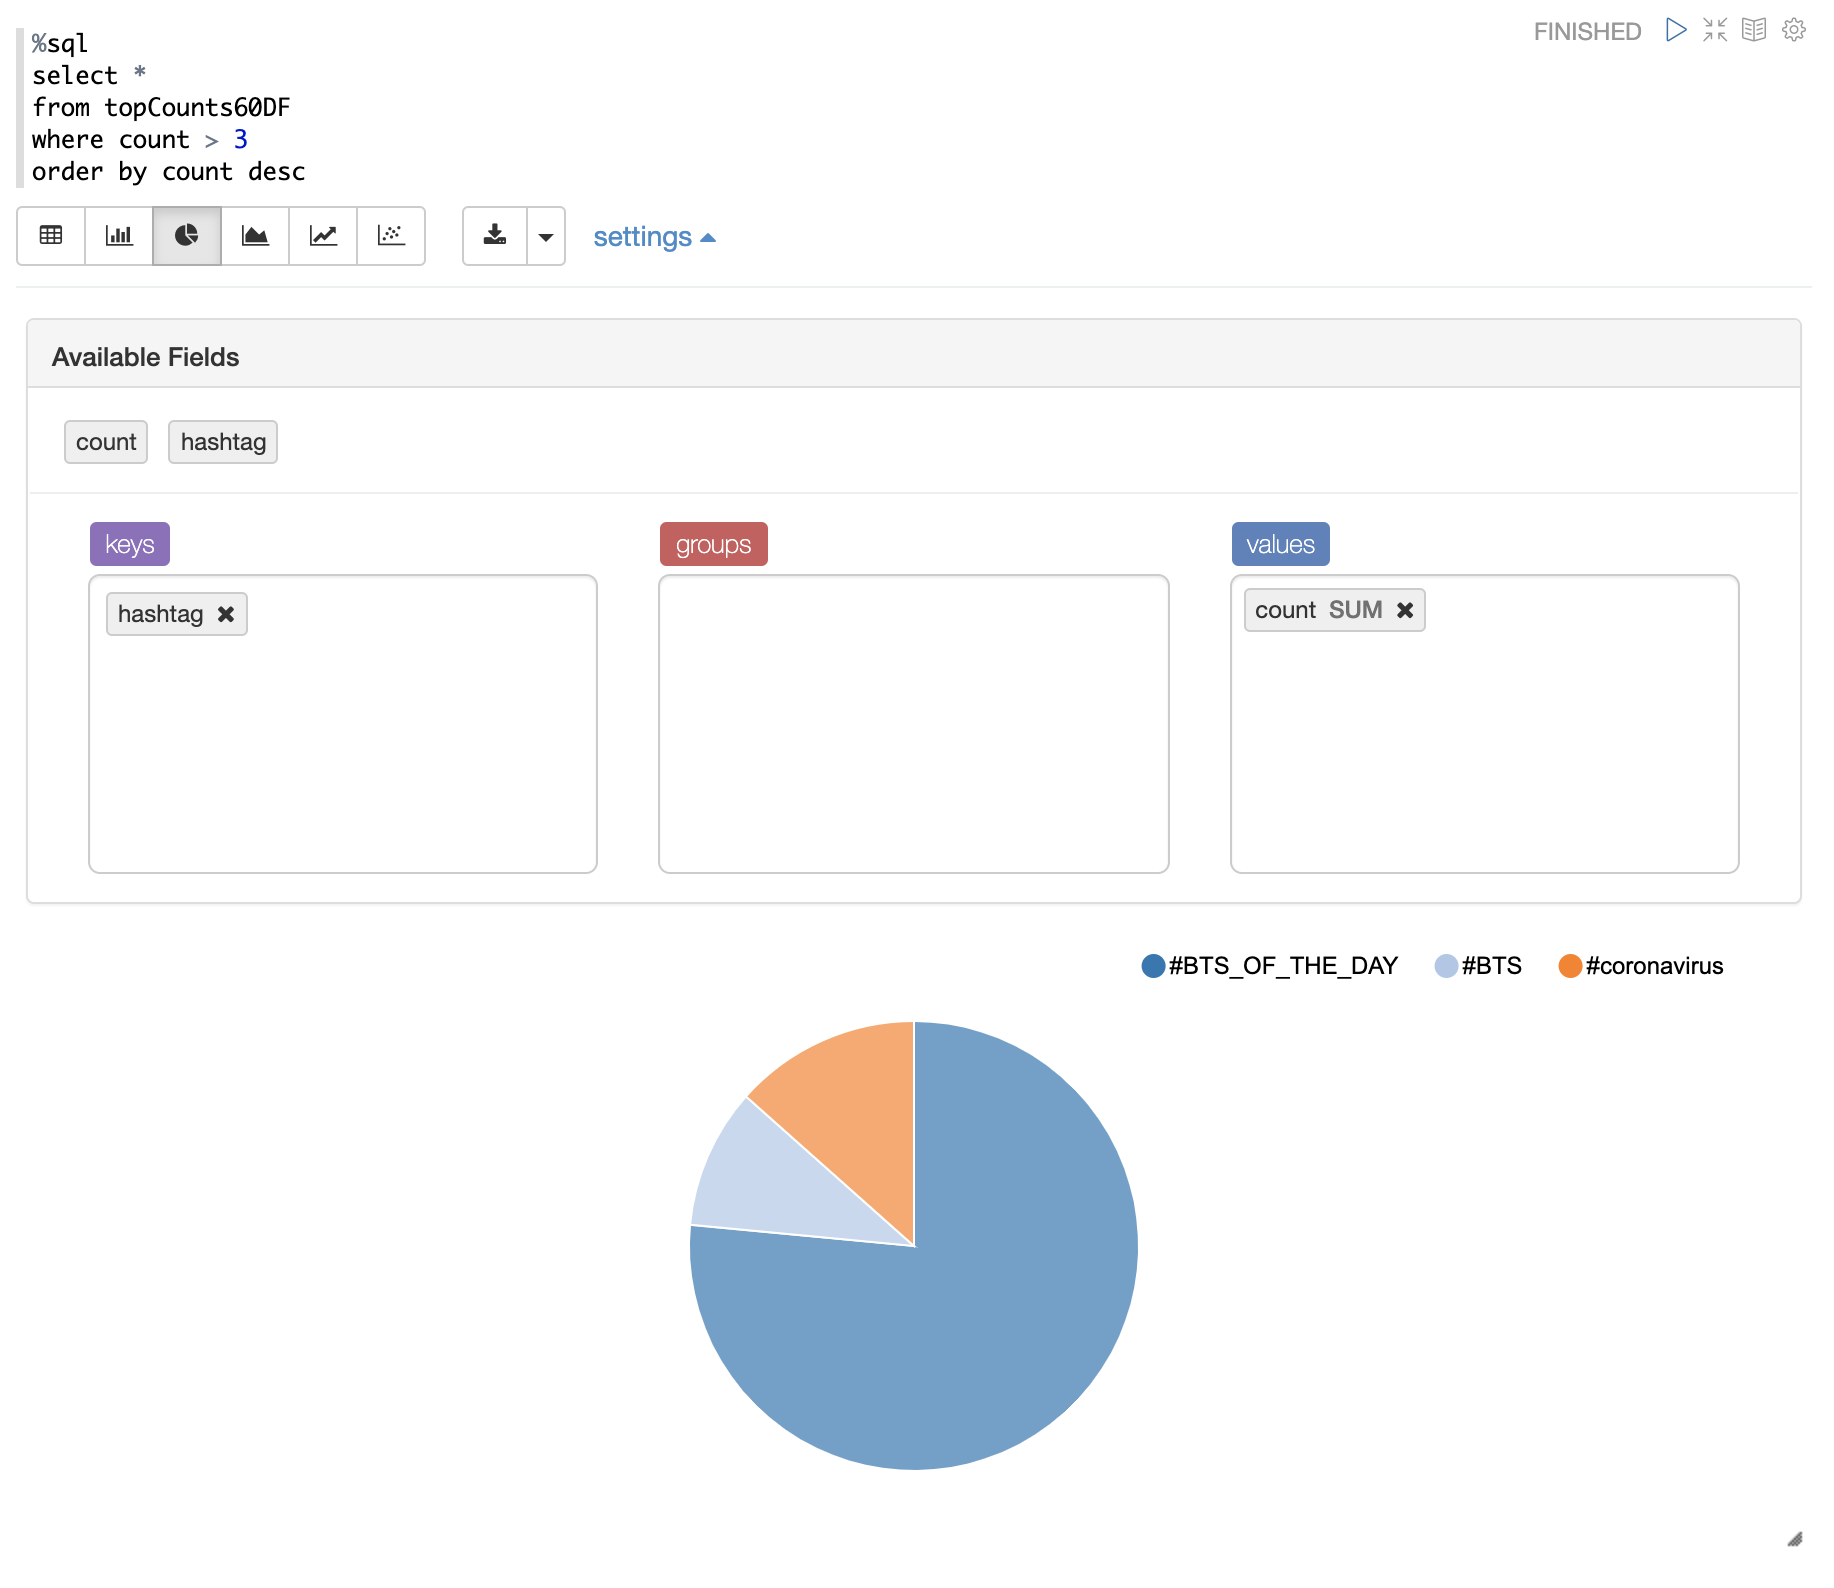

In [9]:
Image('./capture/05_twitter.png')

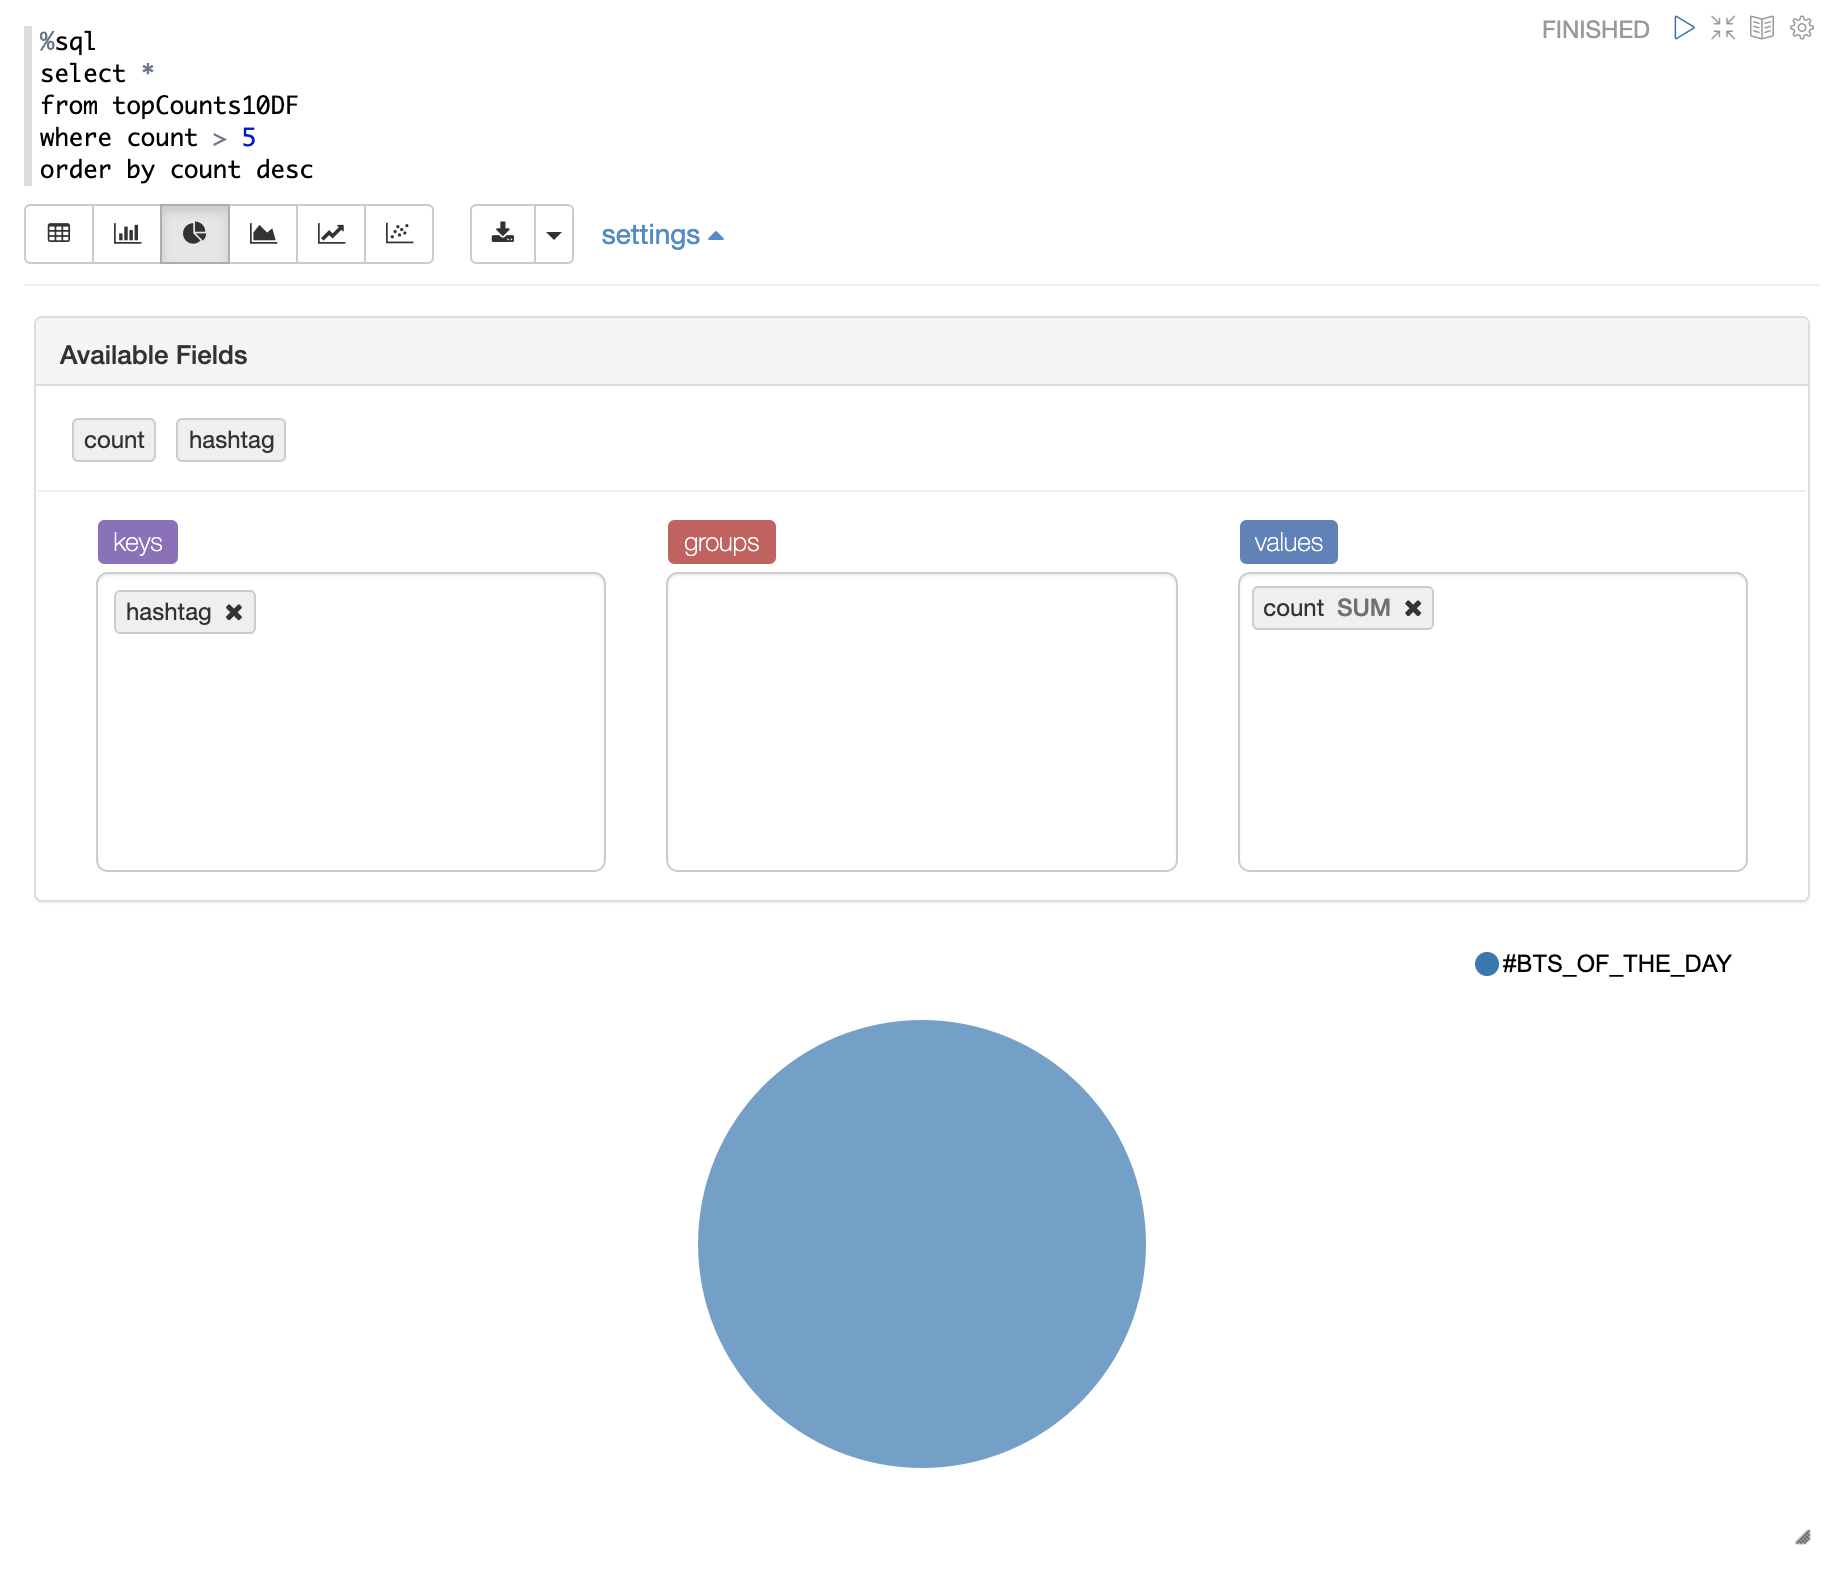

In [10]:
Image('./capture/06_twitter.png')

- spark2 interpreter에 생성했던 spark.jars.packages 삭제
    - spark.jars 수정 
        - /kikang/spark2/mysql-connector-java-8.0.19.jar,/kikang/spark2/org.apache.bahir_spark-streaming-twitter_2.11-2.3.4.jar,/kikang/spark2/org.twitter4j_twitter4j-core-4.0.6.jar,/kikang/spark2/org.twitter4j_twitter4j-stream-4.0.6.jar

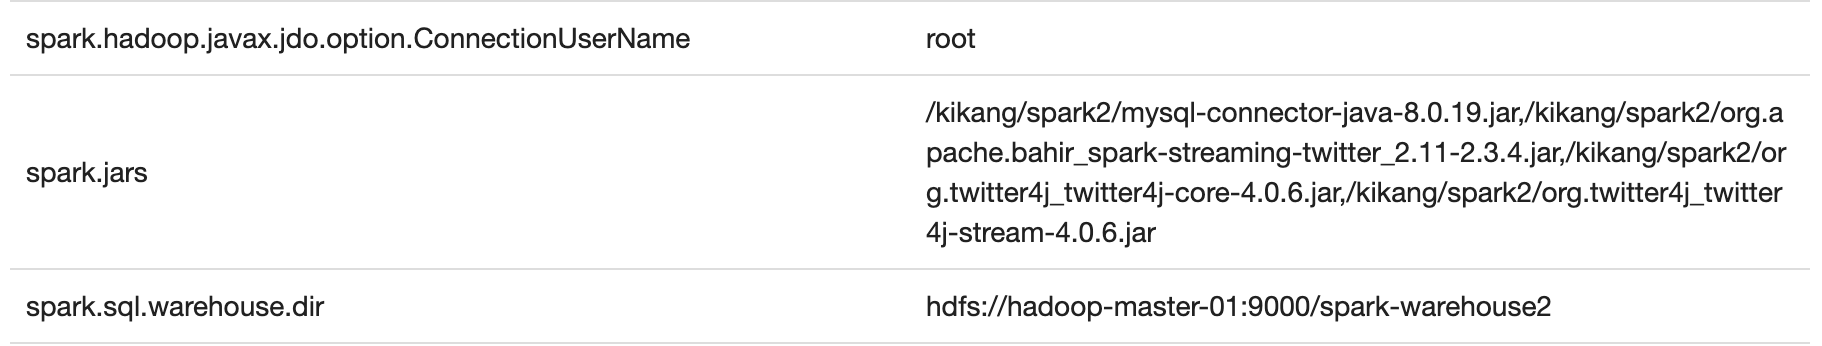

In [12]:
Image('./capture/07_twitter.png')

- interpreter 순서 : spark2를 첫 줄로 올린 후에 restart

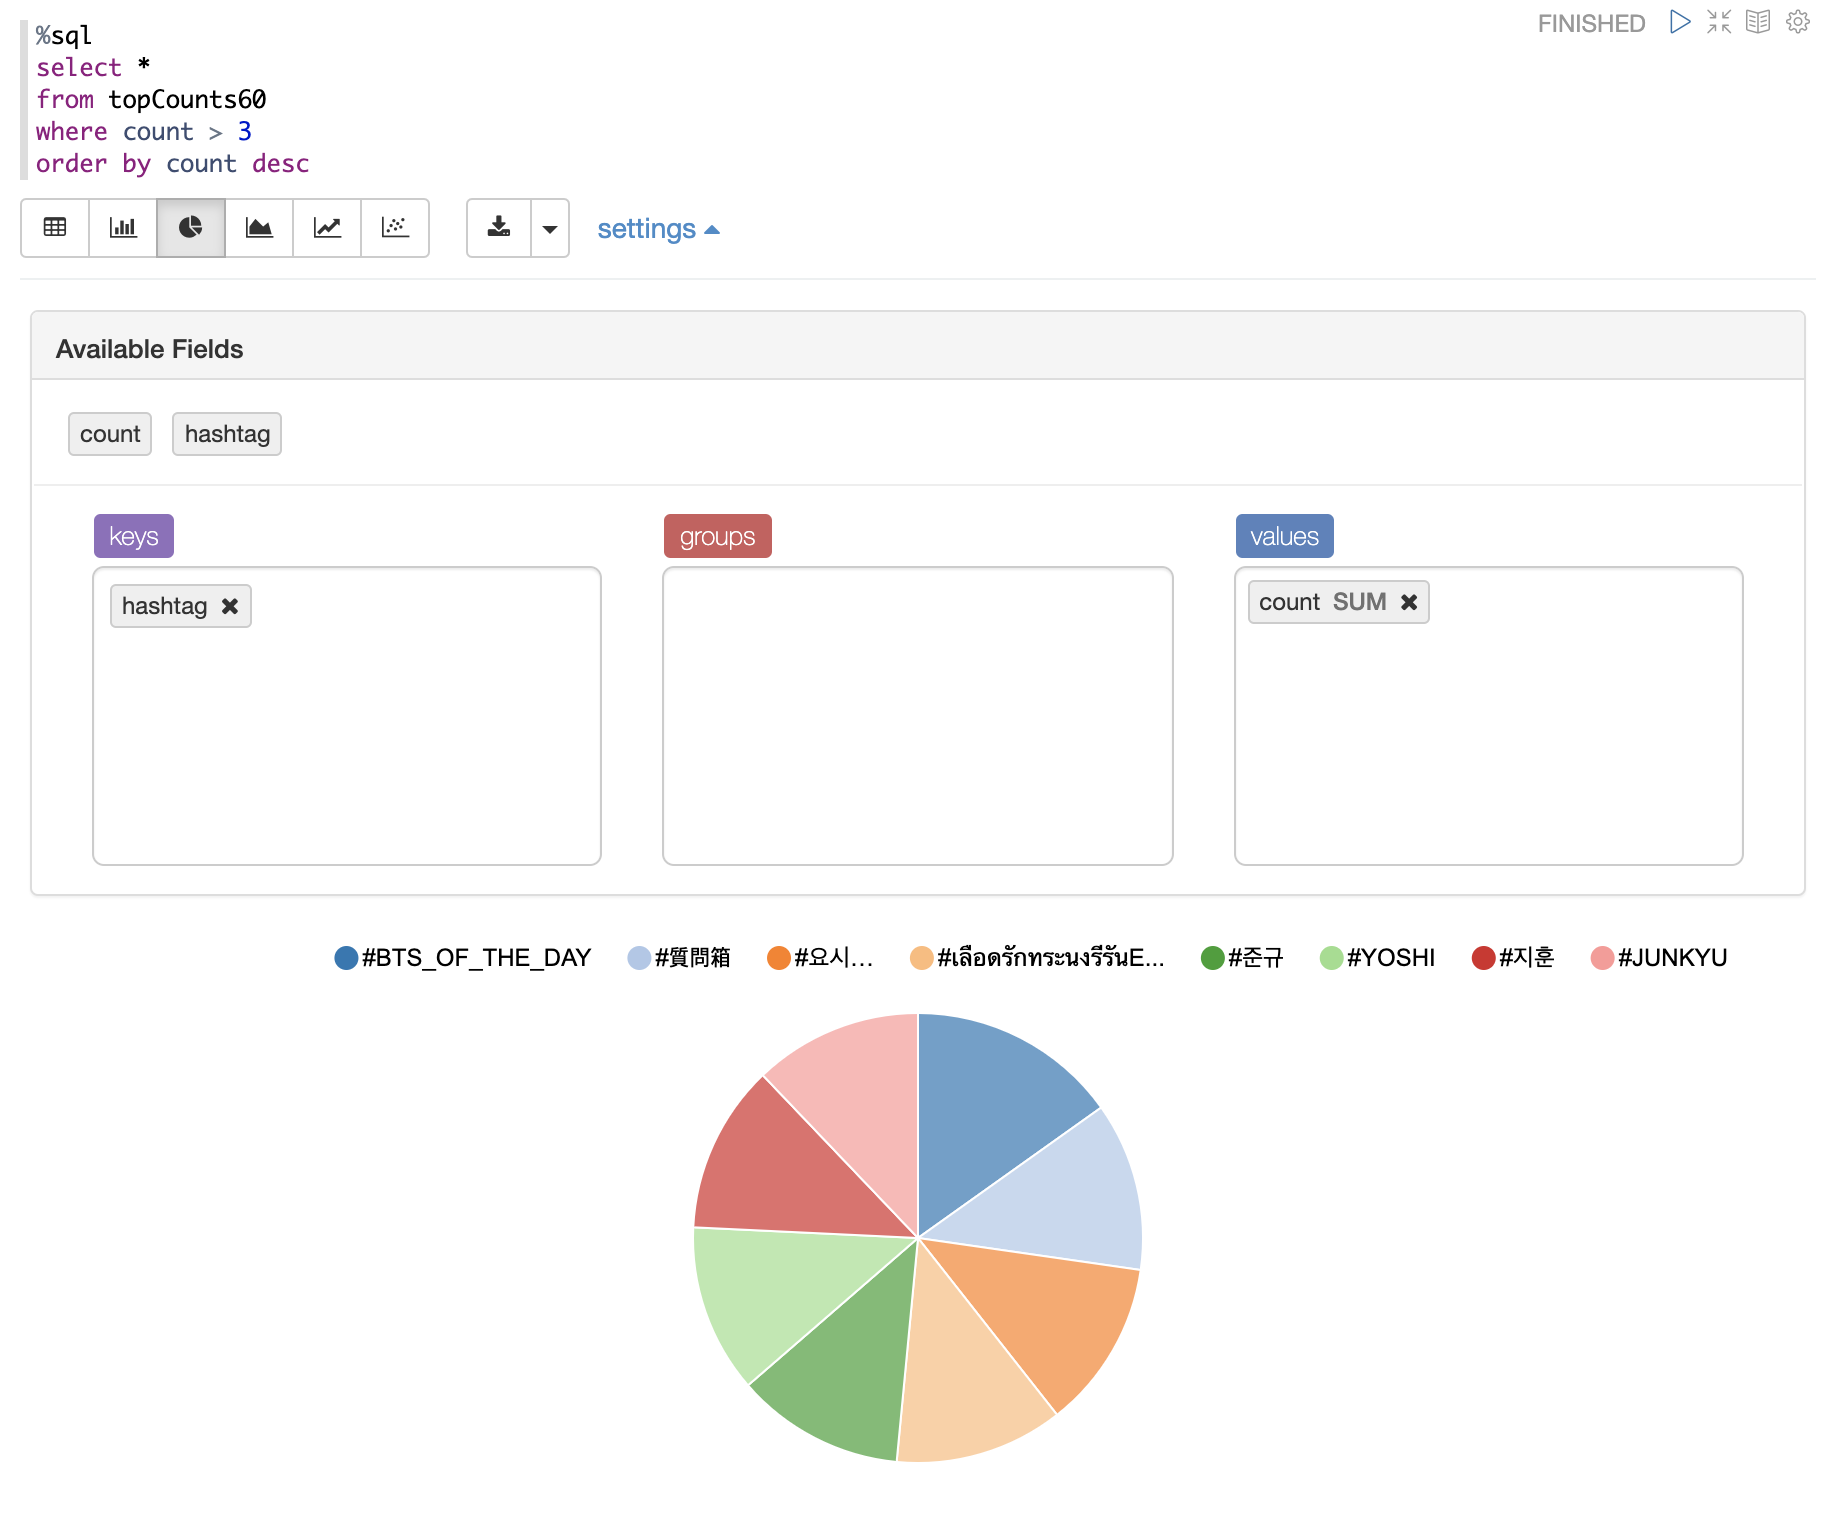

In [13]:
Image('./capture/08_twitter.png')

-----
#### 강의자료 > 0418 > data > afinn > AFINN-111.txt
 
 ------
 - 형태소 분석
 - join(key,value) --> Tuple
 
 ----
 
 afinn 폴더 생성 > afinn-111.txt 파일 업로드

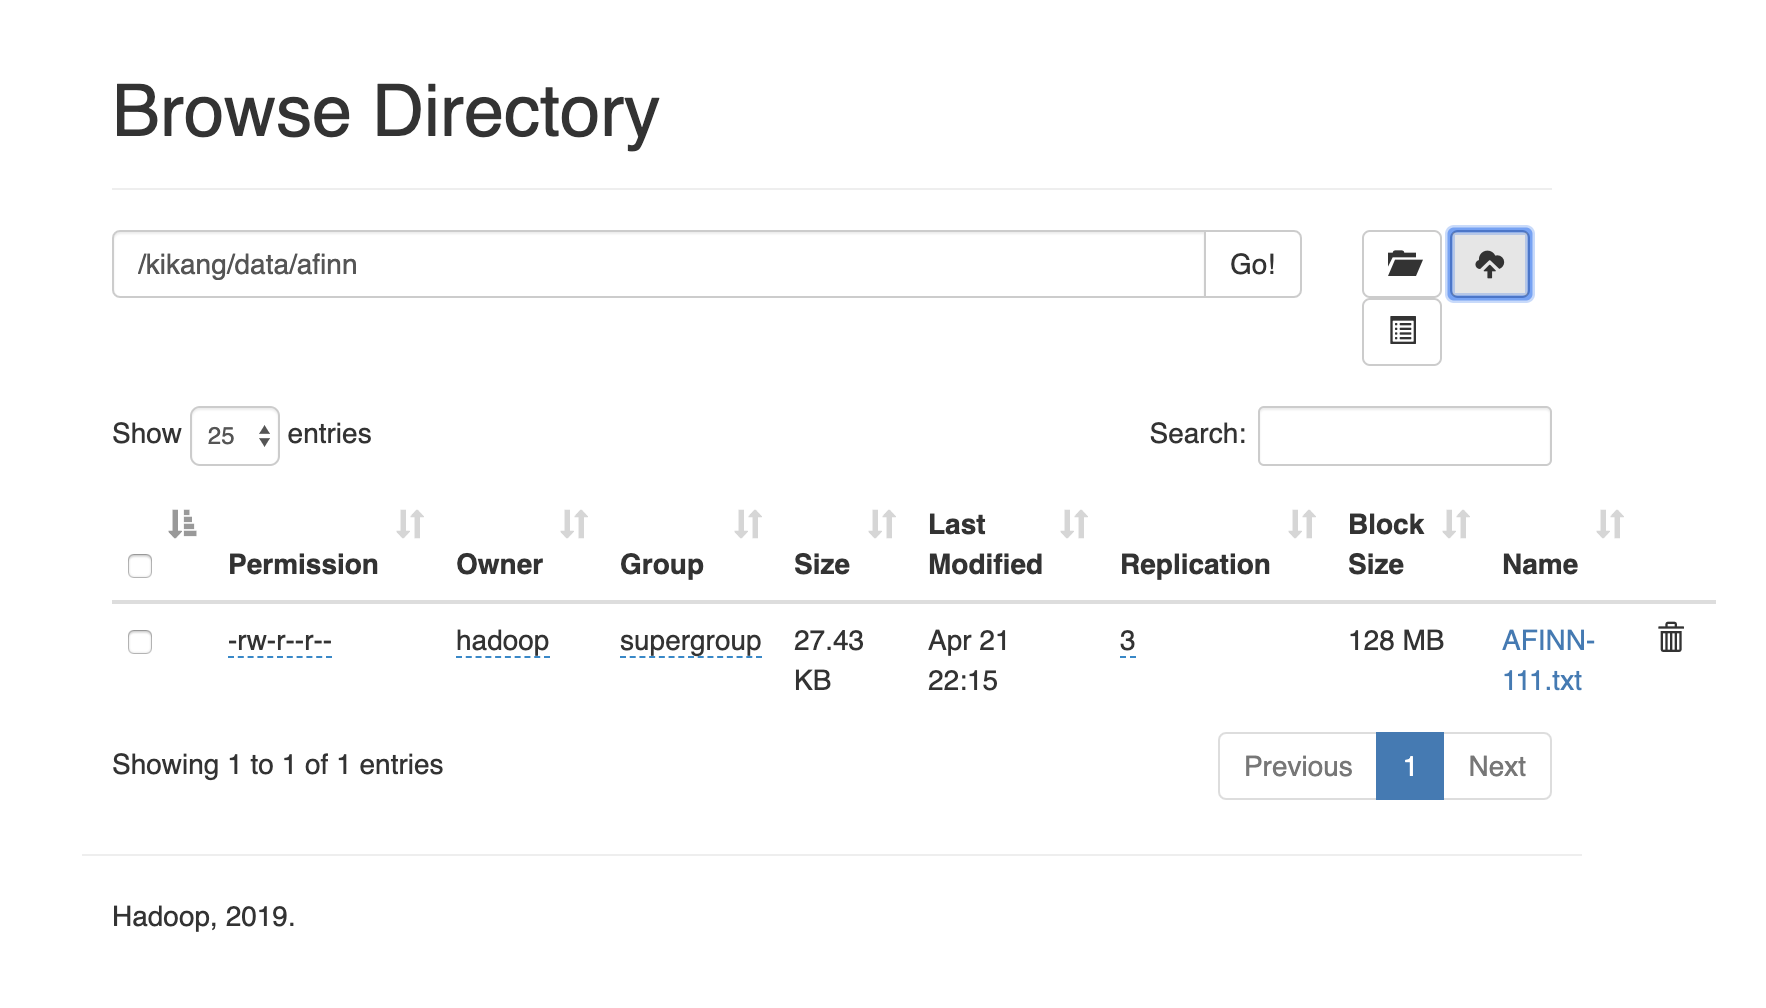

In [14]:
Image('./capture/09_twitter.png')

-----

#### cache 하는 이유 : Batch의 RDD를 cache 하면 join 할 때마다 읽어올 필요가 없음.

 - stream 안에 있는 RDD와 RDD를 join
 - (key, value1) -- join -- (key, value2) --> (key, (value1, value2))
     - value1 * value2 --> 단어별 점수
     
------

#### hashtag 대신 워드로 구성된 스트림 생성

    val hashTags2 = stream.flatMap(status => 
        status.getText.split(" ").filter(_.length() > 3/*_.startsWith("#")*/))
        
-----
#### AFINN RDD 생성 및 cache

    val wordSentimentFilePath = "hdfs://hadoop-master-01:9000/kikang/data/afinn/AFINN-111.txt"
        val wordSentiments = ssc.sparkContext.textFile(wordSentimentFilePath).map { line =>
          val Array(word, happinessValue) = line.split("\t")
          (word, happinessValue.toInt)
        }.setName("WordSentiments").cache()

-----
#### 60s 감성분석

    val happiest60 = hashTags2.map(hashTag => (hashTag/*hashTag.tail*/, 1))
          .reduceByKeyAndWindow(_ + _, Seconds(60))
          .transform{topicCount => wordSentiments.join(topicCount)}  //--join()....
          .map{case (topic, tuple) => (topic, tuple._1 * tuple._2)}
          .map{case (topic, happinessValue) => (happinessValue, topic)}
          .transform(_.sortByKey(false))
          
-----
#### 10s 감성분석

    val happiest10 = hashTags2.map(hashTag => (hashTag, 1))
          .reduceByKeyAndWindow(_ + _, Seconds(10))
          .transform{topicCount => wordSentiments.join(topicCount)}  //--join()....
          .map{case (topic, tuple) => (topic, tuple._1 * tuple._2)}
          .map{case (topic, happinessValue) => (happinessValue, topic)}
          .transform(_.sortByKey(false))

-----
#### 60s 감성분석 RDD > DF > TempView

    happiest60.foreachRDD(rdd => {
         rdd.toDF("happinessValue", "word").createOrReplaceTempView("happiest60")
        })

------
#### 10s 감성분석 RDD > DF > TempView

    happiest10.foreachRDD(rdd => {
         rdd.toDF("happinessValue", "word").createOrReplaceTempView("happiest10")
        })

-----
ssc.start()

----
    %sql
    select * 
    from happiest60

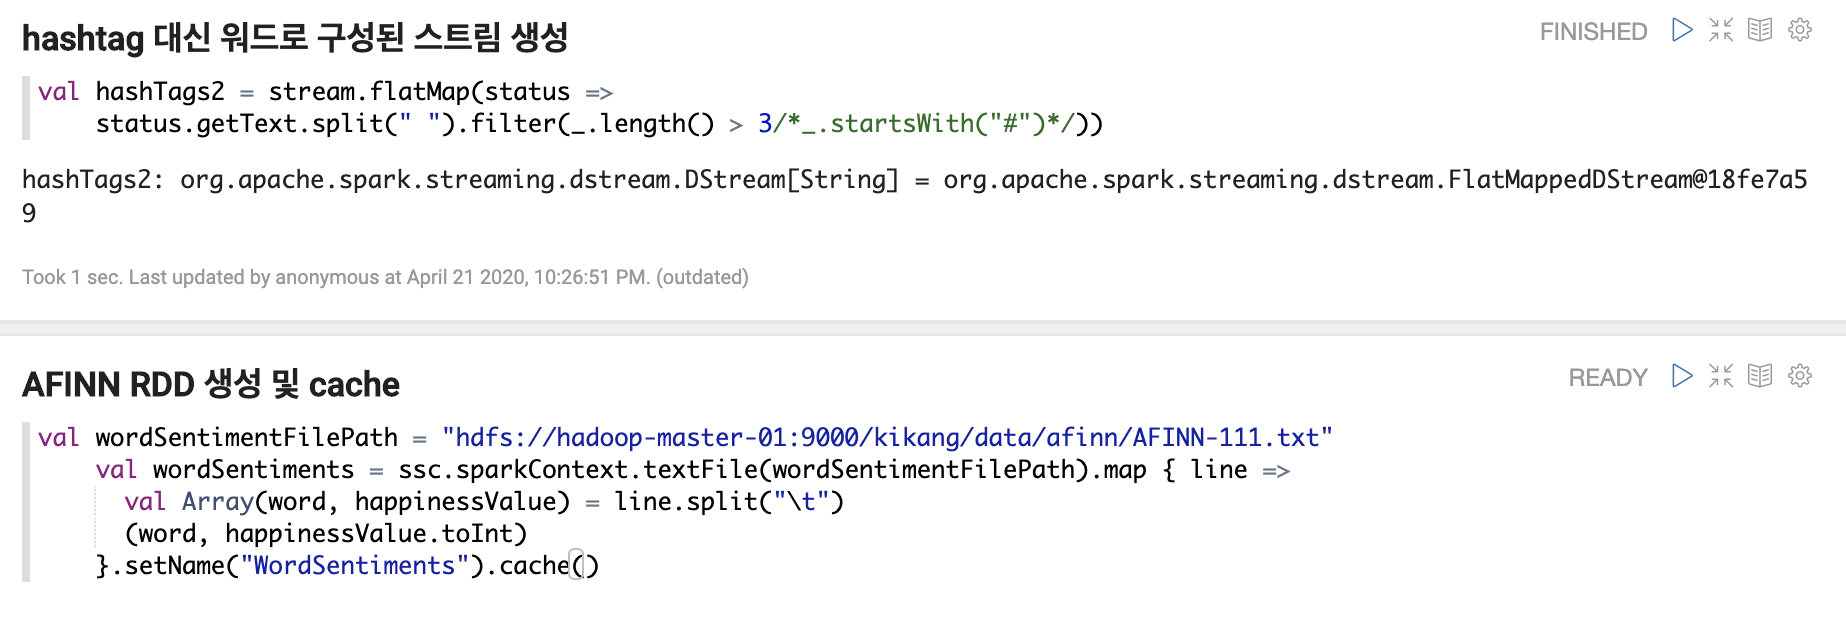

In [15]:
Image('./capture/10_twitter.png')

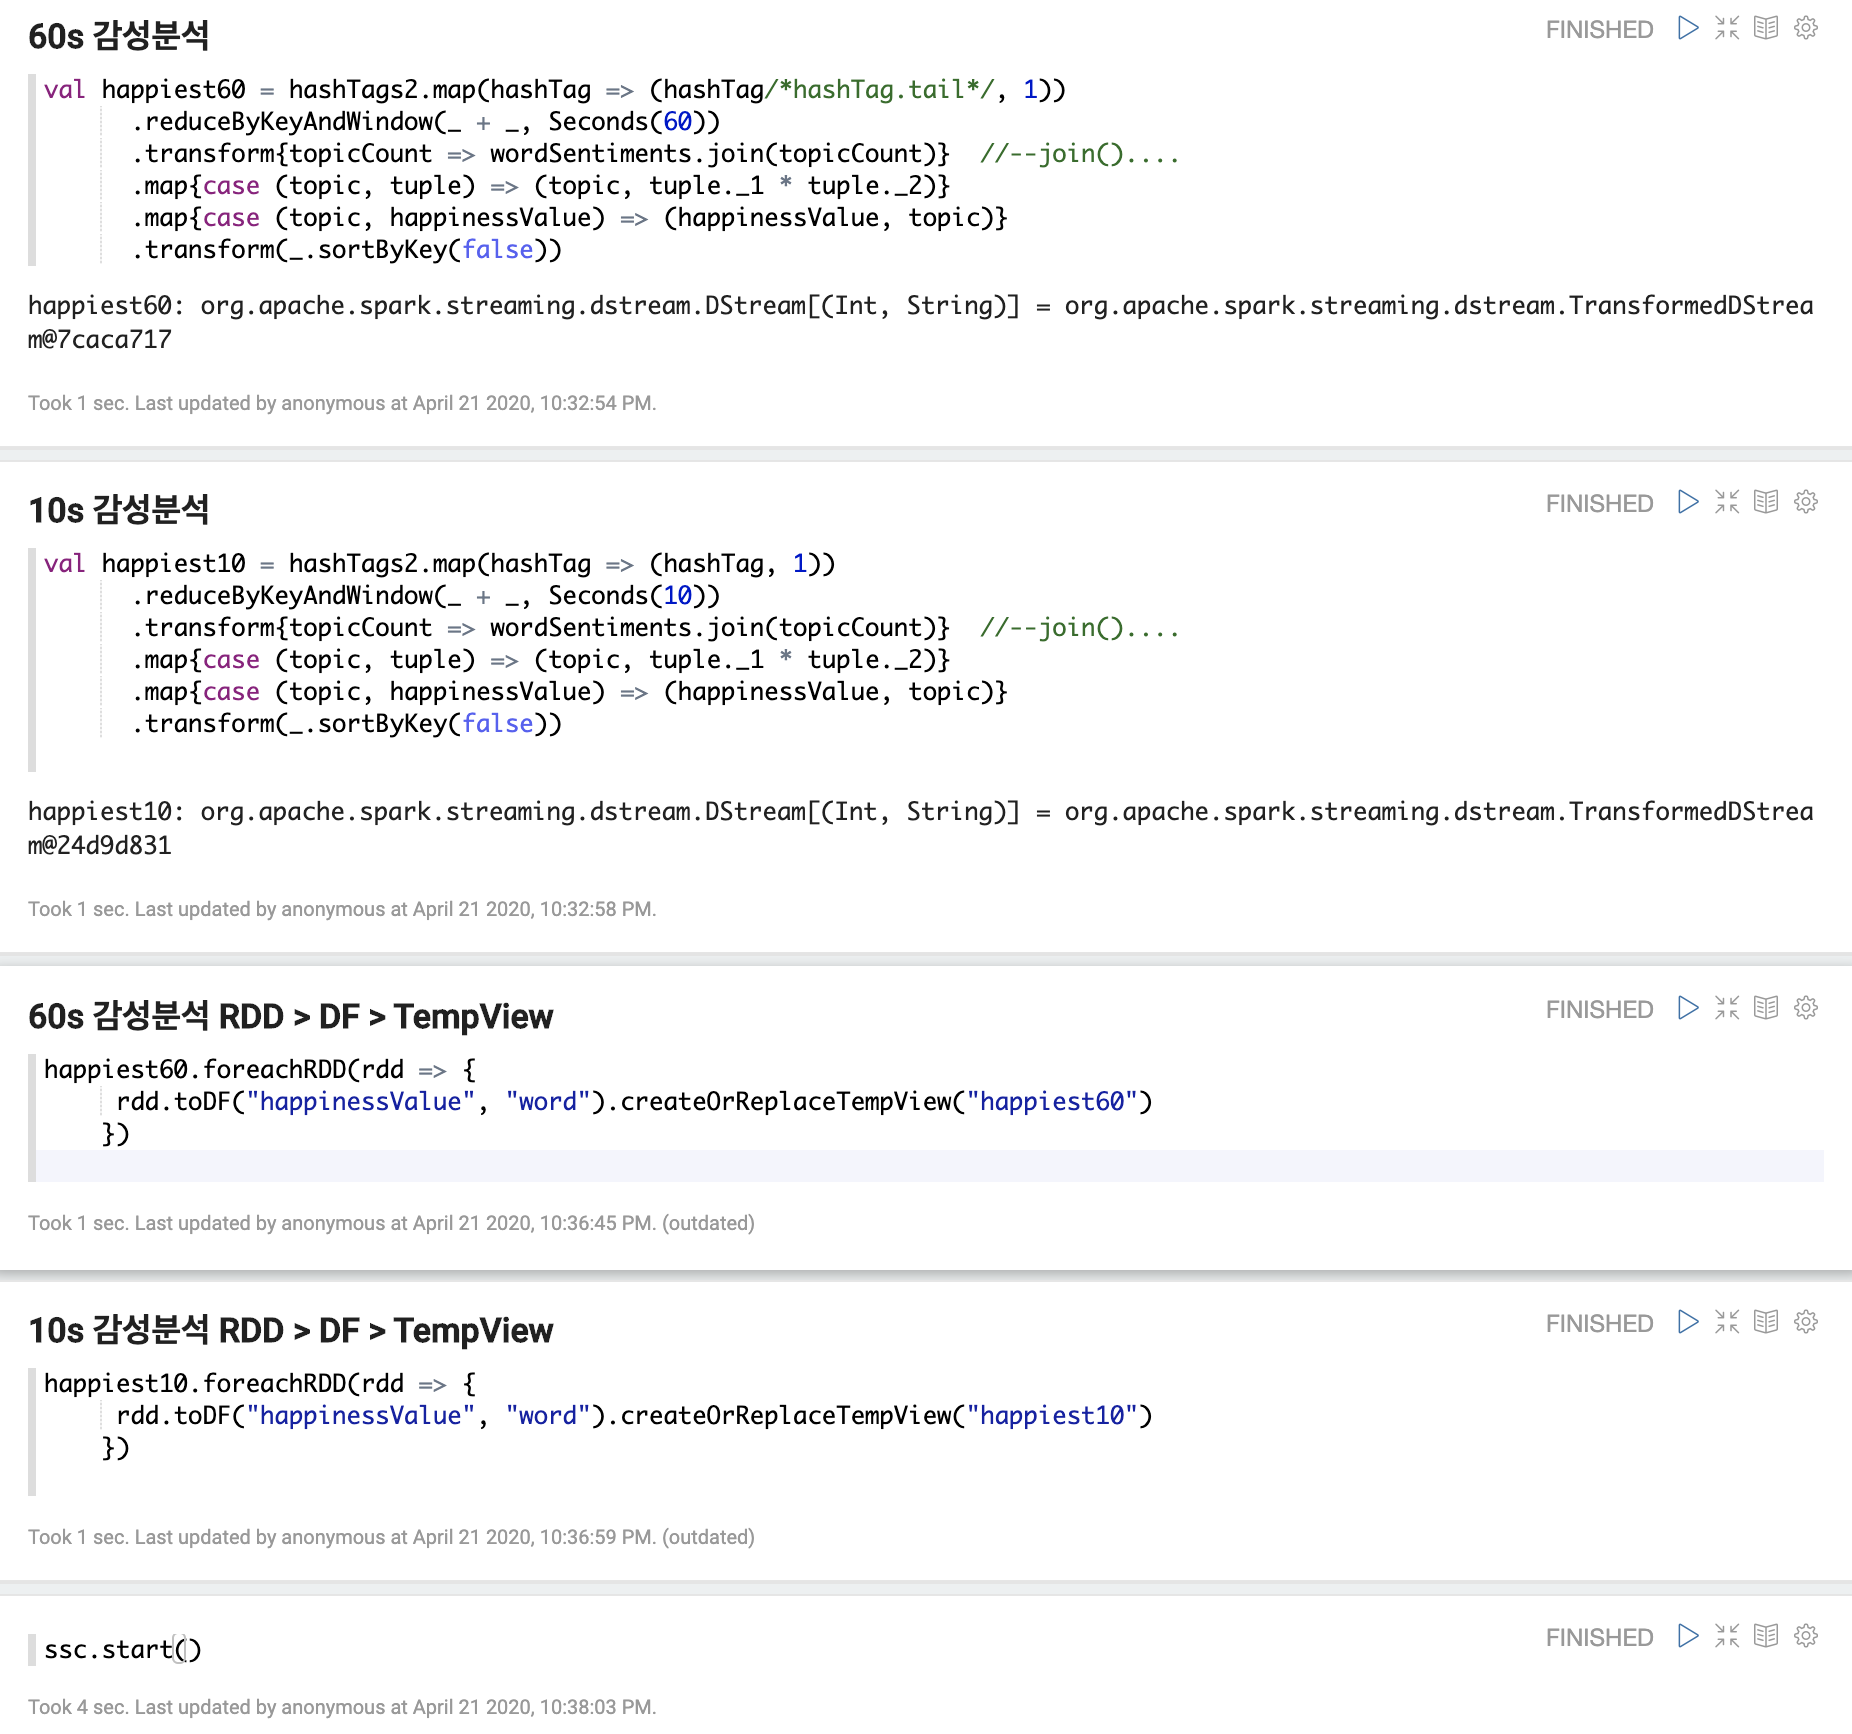

In [16]:
Image('./capture/11_twitter.png')

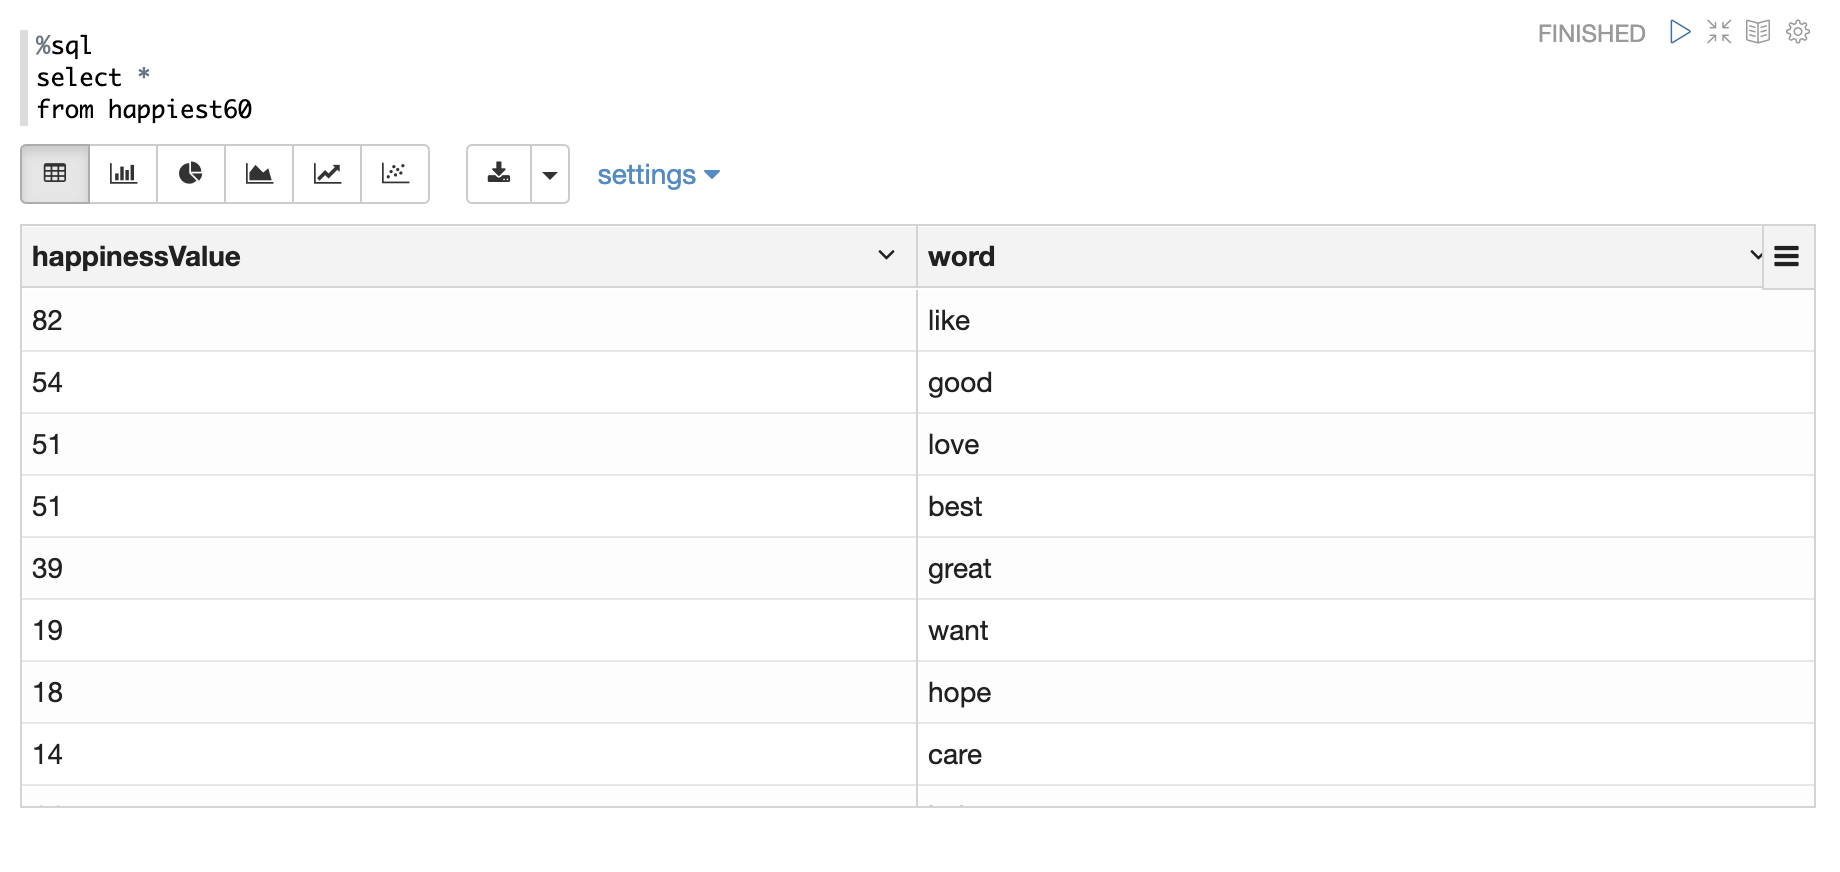

In [17]:
Image('./capture/12_twitter.png')